In [1]:
using DrWatson
@quickactivate :Catalyst
using CSV

input_exp_12 = []
output_exp_12 = []
input_exp_10 = []
output_exp_10 = []
input_exp_8 = []
output_exp_8 = []
    
for row in CSV.File(datadir("experiment/SBA15_interp_12.csv"); delim = ",")
    push!(input_exp_12, row.I)
    push!(output_exp_12, row.O)
end
    
for row in CSV.File(datadir("experiment/SBA15_interp_10.csv"); delim = ",")
    push!(input_exp_10, row.I)
    push!(output_exp_10, row.O)
end
    
for row in CSV.File(datadir("experiment/SBA15_interp_8.csv"); delim = ",")
    push!(input_exp_8, row.I)
    push!(output_exp_8, row.O)
end

┌ Info: Precompiling Catalyst [01e5440a-74e3-4b45-b8b9-c13ddfc5051b]
└ @ Base loading.jl:1273
┌ Warning: /home/mkoehler/.julia/packages/Plots/cc8wh/src/Plots.jl/ is not an existing directory, Revise is not watching
└ @ Revise /home/mkoehler/.julia/packages/Revise/Pcs5V/src/Revise.jl:489


In [2]:
n = 2
nels = (5n, convert(Int,2.5n),n)
S = Vec((0.0,0.0,0.0))
E = Vec((1.0,0.5,0.2))
grid = generate_grid(Tetrahedron, nels, S, E)
faces = union(getfaceset(grid,"top"),getfaceset(grid,"bottom"),getfaceset(grid,"left"),getfaceset(grid,"right"),
                getfaceset(grid,"front"),getfaceset(grid,"back"))
addfaceset!(grid, "1", faces)

Grid{3,Cell{3,4,4},Float64} with 600 Tetrahedron cells and 198 nodes

## Calibration Results

### First all available experiment data was calibrated on its own

| Parameters   | 8 ml/h               | 10 ml/h              | 12 ml/h              |
|--------------|----------------------|----------------------|----------------------|
| $D_i$        | $4.5 \cdot 10^{-15}$ | $4.9 \cdot 10^{-15}$ | $2.3 \cdot 10^{-15}$ |
| $k$          | $2.879$              | $5.379$              | $6.576$              |
| $k_{\Gamma}$ | $2.305$              | $1.075$              | $0.108$              |
| $Q$          | $29.712$             | $21.259$             | $14.153$             |
| $k_n$        | $2.292$              | $0.841$              | $1.565$              |

### Question
**How good does one set of parameters, e.g. of 10ml/h, fit the curves from the other velocities, i.e. are we velocity independent?**

## All curves with the optimized set of parameters with 10 ml/h

In [88]:
c1, R1 = Catalyst.solve(0.0049039, 5.378971, 1.074862, 
                    input_exp_8, output_exp_8, progress=true, 
                    microcomp_type=:nonlinear, 
                    Q=21.25856992, kₙ=0.84133766, 
                    calibration=false, w=1.5302e-4*(1/0.37),micromesh=grid);

macro-scale progress...100%|████████████████████████████| Time: 0:12:21


In [89]:
c2, R2 = Catalyst.solve(0.0049039, 5.378971, 1.074862, 
                    input_exp_10, output_exp_10, progress=true, 
                    microcomp_type=:nonlinear,
                    microsave=true, microsave_time=1:1000, microsave_path="simulation/nonlinear_micro_problem",
                    Q=21.25856992, kₙ=0.84133766,  
                    calibration=false, w=1.9128e-4*(1/0.37),micromesh=grid);

macro-scale progress...100%|████████████████████████████| Time: 0:12:21


In [90]:
c3, R3 = Catalyst.solve(0.0049039, 5.378971, 1.074862, 
                    input_exp_12, output_exp_12, progress=true, 
                    microcomp_type=:nonlinear, 
                    Q=21.25856992, kₙ=0.84133766,
                    calibration=false, w=2.2954e-4*(1/0.37),micromesh=grid);

macro-scale progress...100%|████████████████████████████| Time: 0:12:14


In [93]:
using Plots
using PGFPlotsX

In [105]:
c1_table = Table([1:1000, getindex.(c1,101)]);
c2_table = Table([1:1000, getindex.(c2,101)]);
c3_table = Table([1:1000, getindex.(c3,101)]);
exp1_table = Table([1:1000, output_exp_8[1:1000]]);
exp2_table = Table([1:1000, output_exp_10[1:1000]]);
exp3_table = Table([1:1000, output_exp_12[1:1000]]);

figure = @pgf Axis({width=600, height=400, 
            xlabel="time \$t\$ in \$(s)\$",ylabel="concentration \$c\$ in (mol/m\$^3)\$",
            xlabel_style= {font = raw"\Large"},
            ylabel_style= {font = raw"\Large"},
            legend_style= {font = raw"\Large"},
            yticklabel_style= {font = raw"\Large"},
            xticklabel_style= {font = raw"\Large"},
            "axis_background/.style"={fill="white!89.803921568!black"},
            x_grid_style={"white"},
            y_grid_style={"white"},
            xmajorgrids,
            ymajorgrids,
            ymax=1.05, ymin=-0.05,
            xmax=1010, xmin=-10,
            xtick="{0,100,200,300,400,500,600,700,800,900,1000}",
            ytick="{0, 0.2, 0.4, 0.6, 0.8,1.0}",
            legend_pos="south east"},
        PlotInc({no_markers, color="blue!40!gray", ultra_thick},
                c1_table),
        LegendEntry("Simulation"),
        PlotInc({no_markers, color="blue!40!gray", ultra_thick,forget_plot},
                c2_table),
        PlotInc({no_markers, color="blue!40!gray", ultra_thick,forget_plot},
                c3_table),
        PlotInc({no_markers, color="red!40!gray", ultra_thick},
                exp2_table),
        LegendEntry("Experiment"),
        PlotInc({no_markers, color="red!40!gray", ultra_thick,forget_plot},
                exp3_table),
        PlotInc({no_markers, color="red!40!gray", ultra_thick, style="solid",forget_plot},
                exp1_table),
    )
pgfsave("10mlh-calibration.pdf", figure)

## All curves with optimized set of parameters, when all 3 curves are calibrated simultaenously

### Calibration was very close to the set of parameters, obtained from calibrating the 10ml/h data

In [106]:
c1, R1 = Catalyst.solve(0.003728872, 5.610524587, 1.265918, 
                    input_exp_8, output_exp_8, progress=true, 
                    microcomp_type=:nonlinear, 
                    Q=21.3895419, kₙ=0.8207513998, 
                    calibration=false, w=1.5302e-4*(1/0.37),micromesh=grid);

macro-scale progress...100%|████████████████████████████| Time: 0:12:42


In [107]:
c2, R2 = Catalyst.solve(0.003728872, 5.610524587, 1.265918, 
                    input_exp_10, output_exp_10, progress=true, 
                    microcomp_type=:nonlinear, 
                    Q=21.3895419, kₙ=0.8207513998, 
                    calibration=false, w=1.9128e-4*(1/0.37),micromesh=grid);

macro-scale progress...100%|████████████████████████████| Time: 0:12:06


In [108]:
c3, R3 = Catalyst.solve(0.003728872, 5.610524587, 1.265918, 
                    input_exp_12, output_exp_12, progress=true, 
                    microcomp_type=:nonlinear, 
                    Q=21.3895419, kₙ=0.8207513998, 
                    calibration=false, w=2.2954e-4*(1/0.37),micromesh=grid);

macro-scale progress...100%|████████████████████████████| Time: 0:11:55


In [109]:
c1_table = Table([1:1000, getindex.(c1,101)]);
c2_table = Table([1:1000, getindex.(c2,101)]);
c3_table = Table([1:1000, getindex.(c3,101)]);
exp1_table = Table([1:1000, output_exp_8[1:1000]]);
exp2_table = Table([1:1000, output_exp_10[1:1000]]);
exp3_table = Table([1:1000, output_exp_12[1:1000]]);

figure = @pgf Axis({width=600, height=400, 
            xlabel="time \$t\$ in \$(s)\$",ylabel="concentration \$c\$ in (mol/m\$^3)\$",
            xlabel_style= {font = raw"\Large"},
            ylabel_style= {font = raw"\Large"},
            legend_style= {font = raw"\Large"},
            yticklabel_style= {font = raw"\Large"},
            xticklabel_style= {font = raw"\Large"},
            "axis_background/.style"={fill="white!89.803921568!black"},
            x_grid_style={"white"},
            y_grid_style={"white"},
            xmajorgrids,
            ymajorgrids,
            ymax=1.05, ymin=-0.05,
            xmax=1010, xmin=-10,
            xtick="{0,100,200,300,400,500,600,700,800,900,1000}",
            ytick="{0, 0.2, 0.4, 0.6, 0.8,1.0}",
            legend_pos="south east"},
        PlotInc({no_markers, color="blue!40!gray", ultra_thick},
                c1_table),
        LegendEntry("Simulation"),
        PlotInc({no_markers, color="blue!40!gray", ultra_thick,forget_plot},
                c2_table),
        PlotInc({no_markers, color="blue!40!gray", ultra_thick,forget_plot},
                c3_table),
        PlotInc({no_markers, color="red!40!gray", ultra_thick},
                exp2_table),
        LegendEntry("Experiment"),
        PlotInc({no_markers, color="red!40!gray", ultra_thick,forget_plot},
                exp3_table),
        PlotInc({no_markers, color="red!40!gray", ultra_thick, style="solid",forget_plot},
                exp1_table),
    )
pgfsave("all-three-curves-calibration.pdf", figure)

|**Macro Concentration Evolution**               |**Macro Reaction Evolution**            |
|------------------------------------------------|---------------------------------------------|
| ![Alt Text](calibrated-macro-evolution.gif)    | ![Alt Text](calibrated-reaction-evolution.gif) |

In [123]:
using ProgressMeter
function plotAnimation(storage::Array, gifname::String, xlabel, ylabel, linewidth; lim=(0,1))
    t = 0
    n = length(storage)
    p = ProgressMeter.Progress(n, 0.5, "Creating a gif...")
    anim = @animate for field in storage
        plot(0:5/100:5,field, color="red",ylim = lim, label = "time = $t s", xlabel=xlabel, ylabel=ylabel, linewidth=linewidth, xtickfontsize=12, ytickfontsize=12, legendfontsize=12)
        ProgressMeter.next!(p)
        t += 1
    end

    gif(anim, gifname, fps = 24)
end

plotAnimation (generic function with 1 method)

Creating a gif...100%|██████████████████████████████████| Time: 0:00:41
┌ Info: Saved animation to 
│   fn = /home/mkoehler/Repos/advection-diffusion-catalysis/notebooks/calibrated-macro-evolution.gif
└ @ Plots /home/mkoehler/.julia/packages/Plots/cc8wh/src/animation.jl:98


Plots.AnimatedGif("/home/mkoehler/Repos/advection-diffusion-catalysis/notebooks/calibrated-macro-evolution.gif")
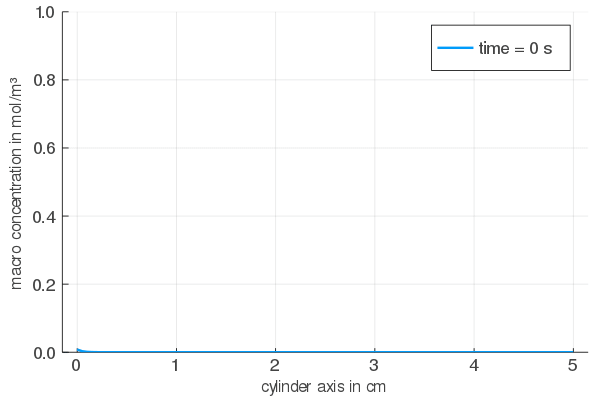

In [118]:
plotAnimation(c2, "calibrated-macro-evolution.gif", "cylinder axis in cm", "macro concentration in mol/m³", 2)

Creating a gif...100%|██████████████████████████████████| Time: 0:00:43
┌ Info: Saved animation to 
│   fn = /home/mkoehler/Repos/advection-diffusion-catalysis/notebooks/calibrated-reaction-evolution.gif
└ @ Plots /home/mkoehler/.julia/packages/Plots/cc8wh/src/animation.jl:98


Plots.AnimatedGif("/home/mkoehler/Repos/advection-diffusion-catalysis/notebooks/calibrated-reaction-evolution.gif")
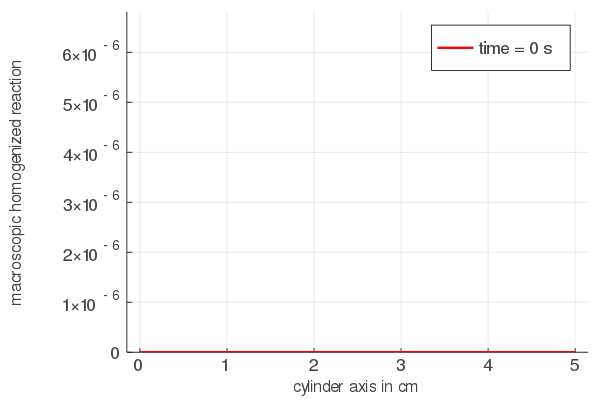

In [124]:
maxR = maximum(maximum.(R2))
maxR *= 1.1
plotAnimation(R2, "calibrated-reaction-evolution.gif", "cylinder axis in cm", "macroscopic homogenized reaction", 2, lim=(0, maxR))